In [16]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Lab 1: Text Corpora and Language Modelling

This lab is meant to help you get familiar with some language data, and use this data to estimate N-gram language models

First you will use the **Penn Treebank**, which is a collection of newspaper articles from the newspaper 
The Wall Street Journal. The idea is to examine the data and notice interesting properties. This will not take more than a few lines of code.

Then you will use a corpus consisting of **TedX** talks. This you will use to estimate an **N-gram language model** for different orders of N, and use this this for some tasks.

The datasets are on blackboard under course materials. Download the zip and make sure to put the files in the same directory as the notebook.

### Rules
* The lab exercises should be made in **groups of two people**.

* The deadline is **Tuesday 7 nov 16:59**.

* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be `lab1_lastname1_lastname2.ipynb`, so for example `lab1_Jurafsky_Martin.ipynb`.

* The notebook is graded on a scale of **0-10**. The number of points for each question is indicated in parantheses. 

* The questions marked **optional** are not graded; they are an additional challenge for those interested in going the extra mile. 

Notes on implementation:

* You should **write your code and answers in this iPython Notebook** (see http://ipython.org/notebook.html for reference material). If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `# YOUR CODE HERE` comment.
    
    * For theoretical question, put your solution in the YOUR ANSWER HERE cell.
    
* Test your code and **make sure we can run your notebook**

# 1. Penn treebank

## Exercise 1.1 (40 points, 5 points per subquestion )

You are provided with a corpus containing words with their Part-of-Speech tags (POS-tags for short). The format is
**word|POS** (one sentence per line) and the file name is **sec02-22.gold.tagged**. This data is extracted from Sections 02-22 from the Penn Treebank: these sections are most commonly used for training statistical models like POS-taggers and parsers.

**[Hint]** **Figure 10.1** in chapter 10 of Jurafsky and Martin (see [here](https://web.stanford.edu/~jurafsky/slp3/10.pdf)) holds a summary of the 45 POS-tags used in the Penn Treebank tagset together with their meaning and some examples. (If you are keen on learning more about the word-classes represented POS-tags and their definitions you can do a litle reading ahead for next week and already have a look at section 10.1 of the same chapter).

**[Hint]** the Python library [collections](https://docs.python.org/2/library/collections.html) has an object called `Counter` which will come in handy for this exercise.

**(a)** How large is the corpus? (i.e. how **many tokens**). And what is the size of the **vocabulary** used in this corpus? 

Estimate the vocabulary size both by **lowercasing** all the words as well as by leaving the words in their **original orthography**. What is an advantage of lowercasing all the words in your corpus? What is a notable downside? **Give examples.**

In [17]:
from collections import Counter

word_counter = Counter() # this is for the original ortography - dictionary where each word has its number of occurences
word_lower_counter = Counter() # this is for the lowercased words
pos_counter = Counter()
word_poses_tuples = []  # list of (word, POS) - with the original ortography

with open("sec02-21.gold.tagged") as file:
    # word_poses is a list of strings with elements of the form "word|POS"
    word_poses = []
    for line in file:
        word_poses += line.strip().split()
    
    # So the size of the corpus is the length of the word_poses
    corpus_size = len(word_poses)
    print("The corpus is " + str(corpus_size) + " tokens long.")
    
    for word_pos in word_poses:
        word, pos = word_pos.split("|")
        word_poses_tuples.append((word, pos))
        word_counter.update([word])
        
        word = word.lower()
        word_lower_counter.update([word])
        pos_counter.update([pos])
    
    # Then the size of the vocabulary is just the number of distinct words, i.e. the length of word_counter
    print("The size of the vocabulary (with the original ortography) is " + str(len(word_counter)) + " words.")
    
    print("The size of the lowercased vocabulary is " + str(len(word_lower_counter)) + " words.\n")
    
    print("The word 'then' appears " + str(word_lower_counter['then']) + " times, out of which " + str(word_counter['then']) + " times starting with a lowercase letter, and " + str(word_counter['Then']) + " times starting with an uppercase letter.")


The corpus is 929552 tokens long.
The size of the vocabulary (with the original ortography) is 44210 words.
The size of the lowercased vocabulary is 39384 words.

The word 'then' appears 409 times, out of which 333 times starting with a lowercase letter, and 76 times starting with an uppercase letter.


By lowercasing all the words in the corpus we regard a word as being the same for whatever position it 
  has in the sentence. For instance, the word "then" appears 409 times, out of which 76 times it appears
  with an uppercase (i.e. "Then") and 333 times with a lowercase (i.e. "then"). When the lowercased we 
  consider both "Then" and "then" as being the same word.

The advantage of lowercasing is hence that it enables us to analyse words disregarding their position in
  the sentence.

A downside of lowercasing is that if a proper name (i.e. abbreviation of concepts, names of pople etc.) 
  coincide with a word in the text, they will be regarded as the same word. For instance, "Motors" appear
  both within the context of the name of a company s name ("General|NNP Motors|NNP Corp.|NNP") and as the
  noun ("(...) for|IN Minuteman|NNP missile|NN rocket|NN motors|NNS .|.")
  Yet another example is with "NO" and "no". The first appears appears once only when referring to an organisation
  ("A|DT crusade|NN of|IN NO|UH to|TO the|DT consumption|NN of|IN drugs|NNS is|VBZ imperative|JJ .|. ")
  while "no" appears 691 times as a negation (e.g. "Mr.|NNP Dinkins|NNP will|MD probably|RB have|VB no|DT choice|NN").
  The two obviously have different meanings, and their meaning become ambiguous when lowercasing.

------
For the rest of this exercise you should use the **original orthography** of the data when answering the questions.

------


**(b)** Plot a graph of word frequency versus rank of a word, in this corpus. Does this corpus obey **Zipf’s law**?

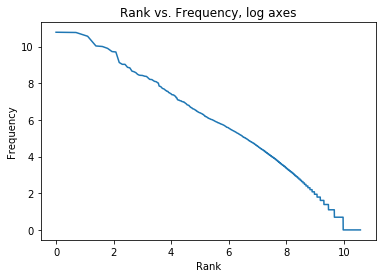

In [18]:
import matplotlib.pyplot as plt
from math import log

most_common = word_lower_counter.most_common() # list of most common words; each element has theform (word, no_occurences)
words = [word[0] for word in most_common] # this is the list of words orderedby their number of occurences
frequencies = [word[1] for word in most_common] # this is the number of occurences of each of the word
log_frequencies = [log(frequency) for frequency in frequencies]

# Now we make the plot of the rank versus frequency (log axes)
x_axis = range(1, len(words)+1)
log_x_axis = [log(x) for x in x_axis]
# We could also have used plt.loglog
plt.plot(log_x_axis, log_frequencies)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Rank vs. Frequency, log axes")
plt.show()

**(c)** What are the **20 most common words** in the corpus and how often do they occur? What is the 50th most common word, the 100th and the 1000th and how often do they occur?

In [19]:
# The following function is for printing purposes only
def count_end(no):
    if no % 10 == 1:
        ending = 'st'
    elif no%10 == 2:
        ending = 'nd'
    elif no%10 == 3:
        ending = 'rd'
    else:
        ending = 'th'
    return ending

for rank, word_count in enumerate(most_common[:20]):
    print("The " + str(rank + 1) + count_end(rank+1)+ " most common word is '" + word_count[0] + "' and appears", word_count[1], "many times.")

for rank in [49, 99, 999]:
    print("The " + str(rank + 1) + count_end(rank+1)+ " most common word is '" + most_common[rank][0] + "' and appears", most_common[rank][1], "many times.")


The 1st most common word is ',' and appears 48310 many times.
The 2nd most common word is 'the' and appears 47666 many times.
The 3rd most common word is '.' and appears 38798 many times.
The 4th most common word is 'of' and appears 22858 many times.
The 5th most common word is 'to' and appears 22210 many times.
The 6th most common word is 'a' and appears 20031 many times.
The 7th most common word is 'in' and appears 16824 many times.
The 8th most common word is 'and' and appears 16458 many times.
The 9th most common word is ''s' and appears 9264 many times.
The 10th most common word is 'that' and appears 8396 many times.
The 11st most common word is 'for' and appears 8377 many times.
The 12nd most common word is '$' and appears 7125 many times.
The 13rd most common word is 'is' and appears 6925 many times.
The 14th most common word is 'it' and appears 5792 many times.
The 15th most common word is 'said' and appears 5606 many times.
The 16th most common word is 'on' and appears 5335 ma

**(d)** How many different Part-of-speech tags are present in the corpus?

In [20]:
print("There are", len(pos_counter.most_common()), "distinct POS tags in the corpus.")

There are 48 distinct POS tags in the corpus.


**(e)** Print a list of the **10 most commonly occurring POS tags** in the data. For each of these POS tags, what are the **3 most common words** that belong to that class?

In [21]:
for index, pos in enumerate(pos_counter.most_common()[:10]):
    answer = "The " + str(index+1) + count_end(index + 1) + " most commonly occuring POS tag is '"+ pos[0] + "'. "
    
    # Now we find thhe most common occuring words
    words_with_pos = list(filter(lambda x: x[1] == pos[0], word_poses_tuples))
    words_pos_counter = Counter(list(map(lambda x: x[0], words_with_pos)))
    most_common_3_words_pos = words_pos_counter.most_common()[:3]
    answer = answer + "The three most common words with this POS tag are: "
    answer = answer + "'" + most_common_3_words_pos[0][0] + "', '" + most_common_3_words_pos[1][0] + "', and '" + most_common_3_words_pos[2][0] + "'."
    
    print(answer)
    

The 1st most commonly occuring POS tag is 'NN'. The three most common words with this POS tag are: '%', 'company', and 'year'.
The 2nd most commonly occuring POS tag is 'IN'. The three most common words with this POS tag are: 'of', 'in', and 'for'.
The 3rd most commonly occuring POS tag is 'NNP'. The three most common words with this POS tag are: 'Mr.', 'U.S.', and 'Corp.'.
The 4th most commonly occuring POS tag is 'DT'. The three most common words with this POS tag are: 'the', 'a', and 'The'.
The 5th most commonly occuring POS tag is 'JJ'. The three most common words with this POS tag are: 'new', 'other', and 'last'.
The 6th most commonly occuring POS tag is 'NNS'. The three most common words with this POS tag are: 'years', 'shares', and 'sales'.
The 7th most commonly occuring POS tag is ','. The three most common words with this POS tag are: ',', 'underwriters', and '2'.
The 8th most commonly occuring POS tag is '.'. The three most common words with this POS tag are: '.', '?', and '!

**(f)** A single word may have several POS-tags. For example, *record* can be a both a **noun** *(buy a record)* or a **verb** *(record a lecture)*. This make POS-tags extremely useful for **disambiguation**.

What percentage of the words in the vocabulary is **ambiguous**? (i.e. have more than one POS tag?) What are the 10 most frequent combinations of POS tags in the case of ambitguity? Which words are **most ambiguous**? Give some of them.

In [22]:
from collections import defaultdict
from itertools import combinations

# Construct word_dict, a dictionary that for each word has a dictionary containing the possible tags of that word together with its number of occurances
word_dict = defaultdict(Counter)
for word_pos in word_poses_tuples:
    word_dict[word_pos[0]].update([word_pos[1]])

# Find the percentage of ambiguous words
amiguous_words = []
for word, counter in word_dict.items():
    if len(counter.most_common()) > 1:
        amiguous_words.append(word)
print("The percentage of ambiguous words is:", len(amiguous_words)/len(word_dict), '.')
        
# we consider a combination as a two POS combination
pos_comb_counter = Counter()
for word, counter in word_dict.items():
    poses = [pos for pos, count in counter.most_common()]
    poses.sort()
    
    # all poses combinations of length 2 of this word
    word_pos_combinations = list(combinations(poses, 2))
    for combination in word_pos_combinations:
        pos_comb_counter.update([combination])

print("\nThe ten most frequent POS combinations (together with their number of occurences):")
print(pos_comb_counter.most_common(10))

# let c_pos_i(a) be the number of times word a is used with pos_i
# let c_max(a) = max count over all pos_i in POS, c_pos_i(a)
# we consider a word a more ambigiuous than word b if
# c_max(a) - (sum c_pos_i(a) for pos_i in POS, excluding the maximum pos )

most_ambiguous = []
for word, counter in word_dict.items():
    # we grab the count of the most frequent POS for word
    c_max_a = word_dict[word].most_common(1)[0][1]
    # and subtract the counts of the rest
    others = sum([count for pos, count in word_dict[word].most_common()[1:]])
    most_ambiguous.append((word, c_max_a - others))
most_ambiguous.sort(key=lambda x: x[1])

answer = "\nThe top five most ambiguous words are "
for i in range(4):
    answer += "'" + most_ambiguous[i][0] + "', "
answer += 'and ' + "'" + most_ambiguous[4][0] + "'."
print(answer)

The percentage of ambiguous words is: 0.13469803211943 .

The ten most frequent POS combinations (together with their number of occurences):
[(('VBD', 'VBN'), 1060), (('JJ', 'NN'), 962), (('NN', 'VB'), 775), (('VB', 'VBP'), 752), (('NN', 'NNP'), 627), (('JJ', 'VBN'), 456), (('NN', 'VBP'), 403), (('NN', 'VBG'), 378), (('NNS', 'VBZ'), 364), (('JJ', 'NNP'), 297)]

The top five most ambiguous words are 'close', 'much', 'cut', 'put', and 'show'.


**(g)**  Print some of these words with their multiple POS-tags. Do you **understand the ambiguity**? Use figure 10.1 mentioned above to interpret the POS-tags.

In [23]:
print("Top five most ambiguous words and their POS tags:")
for word, ambiguity_count in most_ambiguous[:5]:
    answer = "- "
    answer += "the word '" + word + "' has POS tags "
    answer += str([pos for pos, count in word_dict[word].most_common()])
    print(answer)  

Top five most ambiguous words and their POS tags:
- the word 'close' has POS tags ['VB', 'NN', 'RB', 'JJ', 'VBP']
- the word 'much' has POS tags ['RB', 'JJ', 'NN']
- the word 'cut' has POS tags ['VB', 'NN', 'VBN', 'VBD', 'VBP', 'JJ']
- the word 'put' has POS tags ['VB', 'VBD', 'VBN', 'NN', 'VBP', 'JJ']
- the word 'show' has POS tags ['VB', 'NN', 'VBP', 'VBZ']


**(h)** Ambiguous words do not account for a great percentage of the vocabulary. Yet they are among the most commonly occuring words of the English language. What **percentage of the dataset is ambiguous**?

In [24]:
no_ambiguous_words = 0 # number of occurences of ambiguous words
for word in amiguous_words:
    no_ambiguous_words += word_counter[word]

# The result is hence the divisionof thhe number of ambiguous words by the size of the corpus, wich was computed for part (a)
print("The percentage of the data set which is ambiguous is " + str(no_ambiguous_words/corpus_size) + ".")

The percentage of the data set which is ambiguous is 0.5507900580064375.


## Exercise 1.2 (10 points, 5 per subquestion)

You are also provided with another file called **sec00.gold.tagged**. 
Section 00 of the Penn Treebank is typically used as development data.

**(a)** How many **unseen words** are present in the development data (i.e., words that have not occurred in the training data)?

In [25]:
dev_word_poses_tuples = []
dev_word_poses = []
dev_word_counter = Counter()
with open("sec00.gold.tagged") as file:
    # word_poses is a list of strings with elements of the form "word|POS"
    dev_word_poses = []
    for line in file:
        dev_word_poses += line.strip().split()
    
    # So the size of the corpus is the length of the word_poses -- no requirement to print it
    dev_corpus_size = len(dev_word_poses)
    # print("The dev corpus is " + str(dev_corpus_size) + " tokens long.")
    
    for word_pos in dev_word_poses:
        word, pos = word_pos.split("|")
        dev_word_poses_tuples.append((word, pos))
        dev_word_counter.update([word])

# IMPORTANT: We consider unseen words in the original ortography 
unseen_words = set()
for word, count in dev_word_counter.most_common():
    if word not in word_counter:
        unseen_words.add(word)
print("Number of unseen words:", len(unseen_words))

Number of unseen words: 1288


**(b)** What are the three **POS tag categories** that the most **unseen words** belong to?

In [26]:
unseen_pos_counter = Counter()
for word, pos in dev_word_poses_tuples:
    if word in unseen_words:
        unseen_pos_counter.update([pos])

print("Three most common POS for unseen words:")
print(unseen_pos_counter.most_common(3))

Three most common POS for unseen words:
[('NNP', 815), ('JJ', 258), ('NN', 210)]


# 2. Language Models

This part of the lab will be covered in the Wednesday lecture. If you have prior exposure to NLP, go ahead and finish this part! If you don't, start anyway, and this part will be clear after the lecture. 

Reference **chapter 4** of J&M *Language Modeling with N-Grams*. 

----------

Models that assign **probabilities** to **sequences of words** are called language **language
modelels** or **LMs**. The simplest model that assigns probabilities to sentences and sequences of words is the **N-gram** model.

Recall that an *N*-gram language model uses **conditional probabilities** of the form
    
$$P(w_k \mid w_{k-N+1} \dots w_{k-1})$$

to **approximate** the full **joint probability**

$$P(w_1 \dots w_n)$$

of a sequence of words $w_1 \dots w_n$.

The easiest way of obtaining estimates for the probabilities $P(w_k \mid w_{k-N+1} \dots w_{k-1})$ is to use the **maximum likelihood estimate** or **MLE**, a widely used statistical estimation method ([read more]((https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)). You count and normalize:

$$P_{MLE}(w_k \mid w_{k-N+1} \dots w_{k-1}) = \frac{C(w_{k-N+1} \dots w_{k-1} w_k)}{C(w_{k-N+1} \dots w_{k-1})}.$$


## Exercise 2.1 (25 points)

**(a) ** Complete the function `train_ngram` so that you can train a count-based $N$-gram language model on the data found in `data/ted-train.txt` and train this for $N=2,3,4$. **15 points**

**(b) ** Extend the function above so that it accepts a parameter `k` for optional add-$k$ smoothing. **10 points**

**[Datastructure hint]** If you store the smoothed language in a naive manner (that is, to store *all* the numbers separately) your datastructure will get huge! If $V$ is the vocabulary then the smoothed bigram model assigns probabilities to $|V|^2$ entries. If $|V|$ is around 80k, the naive way requires you to store more than 64 billion floats. Yet almost all of these are actually just $P(w_n|w_{n-1}) = \frac{k}{N + k|V|}$, with $k$ the value with which you smooth and $N=C(w_{n-1})$. Think about how you use this fact to make your model work in practice.

**[Python hint]** The `collections` library has another useful datastructure: the `defaultdict`. Some example uses:

In [27]:
from collections import defaultdict

d = defaultdict(float)
d["new key"]

0.0

Compare that to an ordinary dictionary:

In [28]:
d = dict()
d["new key"]

KeyError: 'new key'

Other datatypes as `default_factory`:

In [ ]:
d = defaultdict(int)
d["new key"]

In [ ]:
d = defaultdict(list)
d["new key"]

Converting an already existing `dict`:

In [ ]:
d1 = {k: "value" for k in range(1, 11)}
d = defaultdict(float, d1) # convert it to a defaultdict
print(d[5])
print(d[100])

This doesn't work:

In [ ]:
d = defaultdict(10)

Use a `lambda` to make the number `10` `callable`":

In [ ]:
d = defaultdict(lambda: 10)
d["new key"]

In [ ]:
d = defaultdict(lambda: defaultdict(float))
d["new key"]

Clever use of a `defaultdict` can be the solution to the problem of data-storing in a smoothing $N$-gram pointed out above:
    
    ngram = defaultdict(lambda: k/(N+kV), ngram)

The following function is given:

In [30]:
train_file = "ted-train.txt"

def read(fname, max_lines=np.inf):
    """
    Reads in the data in fname and returns it as
    one long list of words. Also returns a vocabulary in
    the form of a word2index and index2word dictionary.
    """
    data = []
    # w2i will automatically keep a counter to asign to new words
    w2i = defaultdict(lambda: len(w2i))
    i2w = dict()
    start = "<s>"
    end = "</s>"
    
    with open(fname, "r") as fh:
        for k, line in enumerate(fh):
            if k > max_lines:
                break
            words = line.strip().split()
            # assign an index to each word
            for w in words:
                i2w[w2i[w]] = w # trick
            
            sent = [start] + words + [end]
            data.append(sent)

    return data, w2i, i2w

In [31]:
def train_ngram(data, N, k=0):
    """
    Trains an n-gram language model with optional add-k smoothing
    and additionaly returns the unigram model

    :param data: text-data as returned by read
    :param N: (N>1) the order of the ngram e.g. N=2 gives a bigram
    :param k: optional add-k smoothing
    :returns: ngram and unigram
    """
    ngram = defaultdict(Counter) # ngram[history][word] = #(history,word)
    unpacked_data = [word for sent in data for word in sent]
    unigram = defaultdict(float, Counter(unpacked_data)) # default prob is 0.0        
    
    # start with the unigram model
    uni_freq = Counter(unpacked_data)
    
    if N == 2 or N == 3:
        bi_freq = Counter()
        for index in range(0, len(unpacked_data) - 1):
            bi_freq.update([tuple([unpacked_data[index], unpacked_data[index + 1]])])
    
    if N == 3 or N == 4:
        tri_freq = Counter()
        for index in range(0, len(unpacked_data) - 2):
            tri_freq.update([tuple([unpacked_data[index], unpacked_data[index + 1], unpacked_data[index + 2]])])
    
    if N == 4 or N == 5:
        quad_freq = Counter()
        for index in range(0, len(unpacked_data) - 3):
            quad_freq.update([tuple([unpacked_data[index], unpacked_data[index + 1], unpacked_data[index + 2], unpacked_data[index + 3]])])
    
    
    # default probability is 0.0 by default
    unigram = defaultdict(float)
    bigram = defaultdict(lambda: defaultdict(float))
    trigram = defaultdict(lambda: defaultdict(float))
    quadgram = defaultdict(lambda: defaultdict(float))
    
    token_count = len(unpacked_data)
    # just so that implementation of smoothing is easier:
    V = 0
    if k > 0:
        # default probability is k/(N+kV)
        V = len(uni_freq) # vocabulary size
        unigram = defaultdict(lambda N=token_count : k/(N+k*V))
        bigram = defaultdict(lambda: defaultdict(lambda N=token_count : k/(N+k*V)))
        trigram = defaultdict(lambda: defaultdict(lambda N=token_count : k/(N+k*V))) 
        quadgram = defaultdict(lambda: defaultdict(lambda N=token_count : k/(N+k*V))) 
        
    # unigram
    for key, count in uni_freq.most_common():
        unigram[key] = (count + k)/(token_count + V*k)
        
    # print(unigram["close"])
        
    # bigram
    if N == 2:
        for key, count in bi_freq.most_common():
            bigram[tuple([key[0]])][key[1]] = (count + k)/(uni_freq[key[0]] + V*k)
        ngram = bigram
        
        # NOTE THE TRAILING ","
        #print(bigram[("close",)])
        #print(bigram[("close",)]["to"])
    
    # trigram
    if N == 3:
        for key, count in tri_freq.most_common():
            trigram[tuple([key[0], key[1]])][key[2]] = (count + k)/(bi_freq[(key[0], key[1])] + V*k)
        ngram = trigram
        
        #print(trigram[("close", "to")])
        #print(trigram[("close", "to")]["the"])

    # quadgram
    if N == 4:
        for key, count in quad_freq.most_common():
            quadgram[tuple(key[0], key[1], key[2])][key[3]] = (count + k)/(tri_freq[(key[0], key[1], key[2])] + V*k)
        ngram = quadgram
        
        #print("quadrigram")
        #print(quadgram[("close", "to", "the")])
        #print(quadgram[("close", "to", "the")]["edge"])
       
    return ngram, unigram

data, w2i, i2w = read(train_file)

# for next questions:
bigram, unigram = train_ngram(data, N=2, k=0)
trigram, unigram = train_ngram(data, N=3, k=0)
print(bigram[("protons",)])
print(trigram[("protons","and")])

smooth_bigram, smooth_unigram = train_ngram(data, N=2, k=1)
smooth_trigram, smooth_unigram = train_ngram(data, N=3, k=1)
print(smooth_bigram[("protons",)])
print(smooth_trigram[("protons","and")])

defaultdict(<class 'float'>, {',': 0.25, 'start': 0.05, 'are': 0.05, 'have': 0.05, '--': 0.1, 'can': 0.05, '.': 0.1, 'going': 0.05, 'begin': 0.05, 'and': 0.2, 'in': 0.05})
defaultdict(<class 'float'>, {'anti-protons': 0.25, 'leptons': 0.25, 'neutrons': 0.5})
defaultdict(<function train_ngram.<locals>.<lambda>.<locals>.<lambda> at 0x8d6232fc>, {',': 7.70940676114973e-05, 'start': 2.5698022537165765e-05, 'are': 2.5698022537165765e-05, 'have': 2.5698022537165765e-05, '--': 3.854703380574865e-05, 'can': 2.5698022537165765e-05, '.': 3.854703380574865e-05, 'going': 2.5698022537165765e-05, 'begin': 2.5698022537165765e-05, 'and': 6.424505634291442e-05, 'in': 2.5698022537165765e-05})
defaultdict(<function train_ngram.<locals>.<lambda>.<locals>.<lambda> at 0x76f520bc>, {'anti-protons': 2.5703306730410867e-05, 'leptons': 2.5703306730410867e-05, 'neutrons': 3.85549600956163e-05})


In [32]:
data[2]

['<s>',
 'Both',
 'are',
 'necessary',
 ',',
 'but',
 'it',
 'can',
 'be',
 'too',
 'much',
 'of',
 'a',
 'good',
 'thing',
 '.',
 '</s>']

## Exercise 2.2 (5 points)

You can use an *N*-gram language model to **generate text**. The higher the order *N* the better your model will be able to catch the long-range dependecies that occur in actual sentences and the better your changes are at generating sensible text. But beware: **sparsity** of language data will quickly cause your model to reproduce entire lines from your training data; in such cases only one $w_k$ was observed for the histories $w_{k-N+1}\dots w_{k-1}$ in the entire training-set.

**Complete** the function `generate_sent`. It takes a language model `lm` and an order `N` and should generate a sentence by **sampling** from the language model.

**[Hint]** You can use the method of [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to generate a sample from a **categorical distribution**, $p_1\dots p_k$ such that $p_i \geq 0$ and $\sum_{i=1}^k p_i = 1$, as follows:

In [33]:
from random import random

P = [0.2,0.5,0.2,0.1]

def sample(P):
    u = random() # uniformly random number between 0 and 1
    p = 0
    for i, p_i in enumerate(P):
        # I fixed the function
        p += p_i
        if p > u: 
            return i # the first i s.t. p1 + ... + pi > u
        
print(sample(P))

print(Counter([sample(P) for i in range(1000)])) # check to see if the law of large numbers is still true

3
Counter({1: 506, 0: 207, 2: 199, 3: 88})


Inverse transform sampling in the words of Jurafsky and Martin:

> Imagine all the words of the English language covering the probability space
between 0 and 1, each word covering an interval proportional to its frequency. We
choose a random value between 0 and 1 and print the word whose interval includes
this chosen value.

(J&M, section 4.3)

In [34]:
def generate_sent(lm, N):
    sentence = list()
    word = "<s>"
    sentence.append(word)
    
    def model_to_distribution_word_list(lm):
        distribution = []
        words = []
        for key in lm:
            distribution.append(lm[key])
            words.append(key)
        return distribution, words
    
    # we assume lm is a distribution over all of the words with words as keys
    unigram_dist, unigram_words = model_to_distribution_word_list(lm)
    while word != "</s>":
        if N == 1:
            word = unigram_words[sample(unigram_dist)]
        else:
            # we use negative for splicing
            last_words_index = -(N-1)
            # we use bigram when len(sentence) == 1
            # we use trigram when len(sentence) == 2, etc.
            while abs(last_words_index) > len(sentence):
                last_words_index += 1
            previous_words = tuple(sentence[last_words_index:])
            # we first get the distribution we want to condition on
            dist = lm[previous_words]
            # and then we split up that distribution to the actual distribution as list
            #  as well as the list of words in the same order (we might get different orders each time).
            ngram_dist, ngram_words = model_to_distribution_word_list(dist)
            # finally we sample the distribution and map it to a word
            word = ngram_words[sample(ngram_dist)]
        sentence.append(word)
        
    return sentence

sent = generate_sent(bigram, 2)
print(sent)

['<s>', 'I', "'m", 'going', 'to', 'avoid', 'it', 'represent', 'the', 'green', 'revolution', 'that', 'we', "'ve", 'overrun', 'some', 'of', 'food', ',', 'but', 'what', 'the', 'realization', 'that', 'it', '.', '</s>']


### [Optional]

For how many of the histories $w_{k-N+1}\dots w_{k-1}$ is the number of continuations $w_n$ equal to **one**? Calculate the percentage of such cases for the different orders *N*.

And which history has the **most possible continuations**?

In [35]:
### ANSWER ###

## Excercise 2.3 (5 points)

Let $V$ denote our vocabulary. Recall that for any $w$ in $V$ `bigram[w]` defines a conditional probability $p(v|w)$ over $v$ in $V$. In the case of an **unsmoothed bigram**, $p(v|w) = 0$ for most $v\in V$, whereas in the **smoothed bigram** smoothing took care that $p(v|w) \geq 0$ for *all* $v$.

The function `plot_bigram_dist(word, bigram, smoothbigram, k=30)` plots shows $p(v|word)$ for the `k` words $v$. One bar shows the probabilities in `bigram` and one in `smoothbigram`. 

**(a)** Use this function to plot the distribution for at least two words `w` and answer the questions
* What is the effect of smoothing on the bigram distribution of frequent words? 
* What is the effect in the case of infrequent words?
* Explain the difference between the two based on the raw counts of `w` 

**(b)** Now experiment with $k$ much smaller than 1 (but greater than 0!) 
* What are the effects?


**[Hint]** Remember that add-1 smoothing turns 
$$P(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n})}{C(w_{n-1})}$$
into
$$P_{add-1}(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n}) + 1}{C(w_{n-1}) + |V|}.$$

What happens when $C(w_{n-1})$ is relatively big (similiar in of size as $ |V| $)? And what if $C(w_{n-1})$ is small? 

In [36]:
import pandas as pd
import seaborn as sns    

def plot_bigram_dist(word, bigram, smoothbigram, k=30):
    d = bigram[word]
    ds = smoothbigram[word]
    
    # sort the probabilities
    d_sort = sorted(d.items(), reverse=True, key=lambda t: t[1])[0:k]
    ds_sort = sorted(ds.items(), reverse=True, key=lambda t: t[1])[0:k]
    
    _, probs = zip(*d_sort)
    smooth_ws, smooth_probs = zip(*ds_sort)
    
    # make up for the fact that in the unsmoothed case  probs is generally less than k long
    probs = probs + (0,) * (k-len(probs)) 

    w_data = pd.DataFrame({"w": smooth_ws * 2,
                           "P({}|w)".format(word): probs + smooth_probs,
                           "smoothing": ["unsmoothed"]*k + ["smoothed"]*k})
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xticks(rotation=90)
    g = sns.barplot(ax=ax, x="w", y="P({}|w)".format(word), hue="smoothing",
                    data=w_data, palette="Blues_d")    

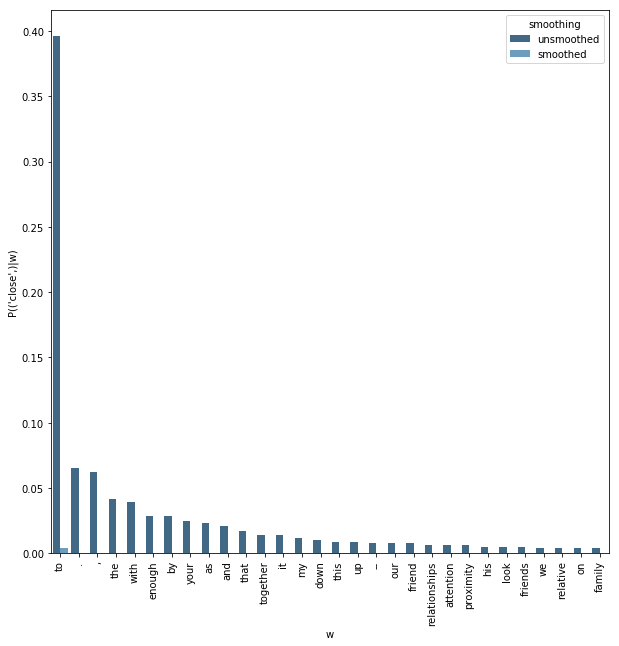

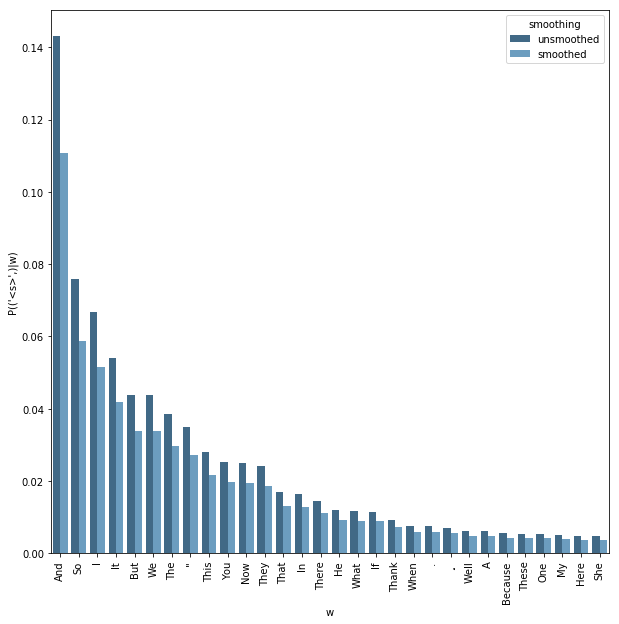

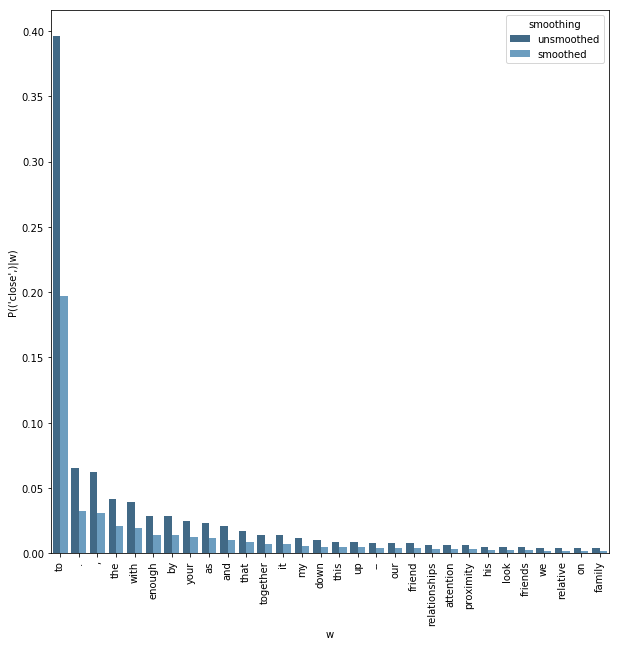

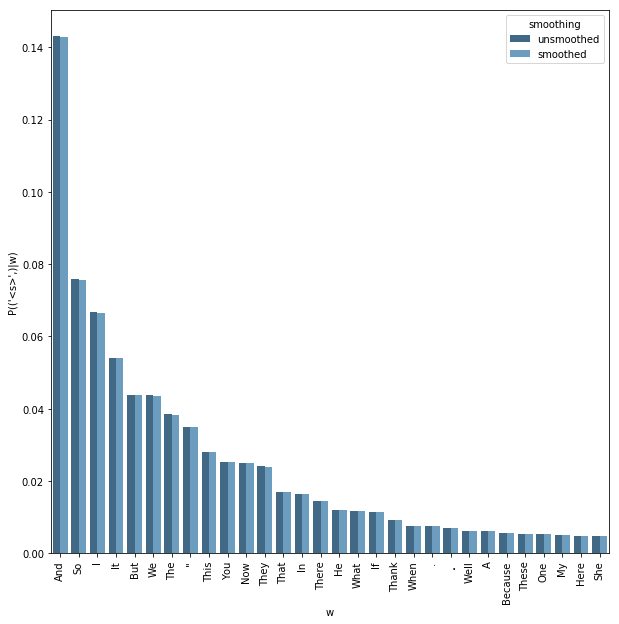

In [37]:
# comment in/out
# plots for k=1
plot_bigram_dist(("close",), bigram, smooth_bigram, 30)
plot_bigram_dist(("<s>",), bigram, smooth_bigram, 30)

#plots for k=0.01
bigram_smoothed_001, unigram_smoothed_001 = train_ngram(data, N=2, k=0.01)
plot_bigram_dist(("close",), bigram, bigram_smoothed_001)
plot_bigram_dist(("<s>",), bigram, bigram_smoothed_001)

a)
What is the effect of smoothing on the bigram distribution of frequent words?
- Given a frequent word w, then the probability of all observed v in V, lets call them v_seen, p(v_seen|w) becomes less after smoothing. The more c(v_seen) then relatively p(v_seen|w) decreses more.

What is the effect in the case of infrequent words?
- Given an infrequent word w. p(v_seen|w) becomes almost the smoothing factor.

Explain the difference between the two based on the raw counts of w
- If w is a frequent word (c(w) >> k*|V|) then the effect of smoothing will have less effect on the distribution. When c(w) << k*|V|, which is usually the case, then the distribution will change dramatically since we "intruduced" K*|V| elements to a distribution which originally had much less elements. I.e. it becomes more uniform.


b)
- With a k << 1 then then we don't introduce as many elements to the distribution so the relative probability decrease becomes almost nonexistent but still we gain the benifit of p(v|w)>0 for all v in V.


**Recall** that if we have a sentence $w_1,\dots,w_n$ we can write

$$P(w_1\dots w_n) = P(w_1)P(w_2|w_1) \cdots P(w_i|w_1 \dots w_{n-1}) \approx P(w_1)P(w_2|w_1)\cdots P(w_{N-1}|w_1\dots w_{N-2})\prod_{i=N}^{n} P(w_i|w_{i-(N-1)}\dots w_{i-1})$$

where in the last step we make an $N$-gram approximation of the full conditionals.

For example, in the case of a bigram (N=2), the above expression reduces to

$$P(w_1 \dots w_n)\approx P(w_1)\prod_{i=2}^{n} P(w_i| w_{i-1}).$$

## Exercise 2.4 (5 points)

The following sentences are taken from the **training data**. Use your **unsmoothed unigram**, **bigram**, and **trigram** language model to estimate their **probabilities**:

    1. Every day was about creating something new .
    2. In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought 
       together in a collision , producing a burst of pure energy .

**Repeat** this with the **smoothed (add-1)** versions of the N-grams. What is the effect of smoothing on the probabilities?


In [38]:
sentence1 = "Every day was about creating something new .".split()
sentence2 = "In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought together in a collision , producing a burst of pure energy .".split()
#print(sentence1)
#print(sentence2)

def compute_prob_of_sentence(sentence, unigram, bigram, trigram):
    # we start by using the unigram and bigram
    prob = unigram[sentence1[0]] * bigram[tuple([sentence1[0]])][sentence1[1]]
    for x in range(0, len(sentence) - 2):
        prob *= trigram[tuple([sentence[x], sentence[x+1]])][sentence[x+2]] 
        
    return prob

# compute the trigram prob of the sentence:
print("Those are the triagram probabilities for each given sentence (using unsmoothened model languages):")
print("- for sentence 1:", compute_prob_of_sentence(sentence1, unigram, bigram, trigram))
print("- for sentence 2:", compute_prob_of_sentence(sentence2, unigram, bigram, trigram))

print("\nThose are the triagram probabilities for each given sentence (using smoothened model languages):")
print("- for sentence 1:", compute_prob_of_sentence(sentence1, smooth_unigram, smooth_bigram, smooth_trigram))
print("- for sentence 2:", compute_prob_of_sentence(sentence2, smooth_unigram, smooth_bigram, smooth_trigram))

# What is the effect of smoothing on the probabilities?
# - The probabilities of the sentences decreases when we introduce smoothing. It decreases dramatically with the length of the sentence.

Those are the triagram probabilities for each given sentence (using unsmoothened model languages):
- for sentence 1: 6.037560695238005e-13
- for sentence 2: 2.9710372188682472e-33

Those are the triagram probabilities for each given sentence (using smoothened model languages):
- for sentence 1: 8.978876519286289e-34
- for sentence 2: 6.183414281667493e-137


- The probabilities of the sentences decreases when we introduce smoothing. It decreases dramatically with the length of the sentence.

## Exercise 2.5 (5 points)

The above sentences were taken from the training set, hence they will all have probability greater than 0. The big challenge for our language model are of course with sentence that contain unseen N-grams: if such an N-gram occurs our model immediately assigns the sentence probability zero.

The following three senteces are taken from the **test set** availlable in the file **ted-test.txt**. What probabilities do your smoothed and unsmoothed language models asign in this case?

    1. Because these robots are really safe .
    2. We have sheer nothingness on one side , and we have this vision of a reality that encompasses every 
       conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible 
       reality .

In [44]:
sentence1 = "Because these robots are really safe .".split()
sentence2 = "We have sheer nothingness on one side , and we have this vision of a reality that encompasses every conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible reality .".split()
#print(sentence1)
#print(sentence2)

# compute the trigram prob of the sentence:
print("Those are the triagram probabilities for each given sentence (using unsmoothened model languages):")
print("- for sentence 1:", compute_prob_of_sentence(sentence1, unigram, bigram, trigram))
print("- for sentence 2:", compute_prob_of_sentence(sentence2, unigram, bigram, trigram))

print("\nThose are the triagram probabilities for each given sentence (using smoothened model languages):")
print("- for sentence 1:", compute_prob_of_sentence(sentence1, smooth_unigram, smooth_bigram, smooth_trigram))
print("- for sentence 2:", compute_prob_of_sentence(sentence2, smooth_unigram, smooth_bigram, smooth_trigram))

# What is the effect of smoothing on the probabilities?
# - The probabilities of the sentences decreases when we introduce smoothing. It decreases dramatically with the length of the sentence.

Those are the triagram probabilities for each given sentence (using unsmoothened model languages):
- for sentence 1: 0.0
- for sentence 2: 0.0

Those are the triagram probabilities for each given sentence (using smoothened model languages):
- for sentence 1: 5.862181500992888e-37
- for sentence 2: 7.694564649677878e-188


- The probabilities of the sentences are 0 in the unsmooth cases as they contain parts which we have not seen before. In the smoothing case the sentences have a probability greater than 0.

### [Optional]

**Optional** What percentage of the sentences in the test set get assigned probability 0 under your smoothed and unsmoothed language models? 

In [40]:
### ANSWER HERE ###

## Exercise 2.6 (5 points)

**Perplexity** is very frequently used **metric** for evaluating probabilistic models such as language models. The perplexity (sometimes called **PP** for short) of a language model on a sentence is the **inverse probability** of the sentence, **normalized** by the number of words:

$$PP(w_1 \dots w_n) = P(w_1\dots w_n)^{-\frac{1}{n}}.$$

Here we can again approximate $P(w_1 \dots w_n)$ with N-gram probabilities, as above.
Note: $(x_1\cdots x_n)^{-\frac{1}{n}}$ is the **geometric mean** of the numbers $x_1,\dots,x_n$. It is like the (regular) artithmetic mean, but with **products** instead of **sums**. The geometric mean is a more natural choice in the case of *PP* because behind $P(w_1\dots w_n)$ is a series of $n$ products ([more here](https://en.wikipedia.org/wiki/Geometric_mean)).



Compute the perplexity of the training sentences from excercise 2.1. What big difference between the **probabilities** of the sentences and the **perplexities** of the sentences do you notice?

In [53]:
sentence1 = "Every day was about creating something new .".split()
sentence2 = "In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought together in a collision , producing a burst of pure energy .".split()

def compute_perplexity_of_sentence(sentence, unigram, bigram, trigram):
    prob = compute_prob_of_sentence(sentence, unigram, bigram, trigram)
    N = len(sentence)
    
    pp = 0
    if prob:
        pp = prob**(-1/N)
        
    return pp

# compute the trigram pp of the sentence:
print("Those are the triagram perplexities for each given sentence (using unsmoothened model languages):")
print("- for sentence 1:", compute_perplexity_of_sentence(sentence1, unigram, bigram, trigram))
print("- for sentence 2:", compute_perplexity_of_sentence(sentence2, unigram, bigram, trigram))

print("\nThose are the triagram perplexities for each given sentence (using smoothened model languages):")
print("- for sentence 1:", compute_perplexity_of_sentence(sentence1, smooth_unigram, smooth_bigram, smooth_trigram))
print("- for sentence 2:", compute_perplexity_of_sentence(sentence2, smooth_unigram, smooth_bigram, smooth_trigram))

Those are the triagram perplexities for each given sentence (using unsmoothened model languages):
- for sentence 1: 33.68156877498604
- for sentence 2: 10.38655731846437

Those are the triagram perplexities for each given sentence (using smoothened model languages):
- for sentence 1: 13515.970964026863
- for sentence 2: 18051.94967910995


We notice that an increase of the probability corresponds to a decrease of the perplexity; this observation imply that the task of minimising the perplexity corresponds to the maximisation of the (test set) probability.

# That's it!

Congratulations, you have made it to the end of the tutorial. Here we will recap the gist of this notebook. 

**Make sure all your cells can be executed and all your answers are there. Then, read on if you're interested!**

-----

By now you should have a solid feeling for the problem of **sparsity in language data**; there's just never enough data. For the task of language modelling, we saw that sparsity is a serious challenge. 

It would be great to be able to model $p(w_n|w_1 \dots w_{n-1})$ for unlimited $n$: the larger $n$ the better our language model should become at capturing the long-range dependencies between words that characterize actual human sentences, and the more probability our model will asign to such sentences as opposed to sentences that are word-soup. But in the N-gram approach, increasing $n$ will quickly kill all generalizing abilities of the model: the model will start to asign probabilities only to sentences it has seen in the training data.

So, where to go from here? Here are three directions that we could head in.

### Smoothing

We have seen one example of smoothing in this lab: add-k smoothing. This is an easy method, both conceptually and implementation-wise. But the results are not great, and the effects it has on the distributions can be extreme.

A much more sophisticated method of smoothing is so-called **Kneser-Ney smoothing**. The method is described in detail in section 4.5 of J&M (3rd edition). This is one of the best performing N-gram smoothing methods, and up to a few years ago a popular implementation of it called [KenLM](https://kheafield.com/code/kenlm/) gave state of the art results.

### From words to characters

In this lab we have considered language modeling as the task of predicting a **word** $w_n$ based on a history of **words** $w_1\cdots w_n$. What if instead we let our basic units of modelling be **characters**? The task then becomes to model $p(c_k\mid c_{k-N-1}\dots c_{k-1})$ where each $c_i$ is now an ASCII character instead of an entire word.

Suddenly sparsity of data is no longer a problem! The set of characters to use is tiny (< 100) compared to even a small-sized vocabulary as today. Have a look at this very illustrative notebook written by Yoav Golberg to see such a method in action: [The unreasonable effectiveness of Character-level Language Models](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139).

(So what is the downside?)


### Neural language models

The above notebook was actually written as a response to this blog post by Andrej Karpathy: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Go ahead and read it if you haven't already: it is a superb introduction to the topic of Recurrent Neural Networks.

Neural language models solve the problem of data sparsity in a different manner. Instead of estimating the probabilities $p(w_k\mid w_{k-N-1}\dots w_{k-1})$ by counting occurences in the data, they use a neural network $f_{\theta}$ parametrized by parameters $\theta$ to predict this probability. The parameters $\theta$ are learned through optimization. 

The simplest approach goes like this: each word in the history $w_{k-N-1}\dots w_{k-1}$ is embedded separately giving  vectors $e_{k-N-1}\dots e_{k-1}$ and then concatenated into one long vectors $[e_{k-N-1};\dots ;e_{k-1}]$. The network then uses this history vector to predict a probability distribution over words $w$ in the vocabulary $V$:

$$p(w \mid w_{k-N-1}\dots w_{k-1}) = f_{\theta}([e_{k-N-1};\dots;e_{k-1}]).$$

(In order to produce legitimate probabilities the final layer of such a network will be for example a $softmax$.)

This provides a solution to the sparsity problem by having the network let the individual embeddings of the words in the history interact through its non-linear transforamtion. We are letting the network figure out the smoothing itself!

RNNs are a clever extension of this idea, where a hidden state vector $h$ is re-used and updated at each step $k$ in order to store the information of the entire history up to step $k-1$. That is, an RNN actually does away with the N-order approximation; it tries to model the full conditional directly! That means that

$$p(w \mid w_1\dots w_{k-1}) \approx RNN_{\theta}([e_{k-1};h_{k-1}])$$

where the hidden state $h_{k-1}$ is a compression of the *entire history* $w_1\dots w_{k-1}$.

Another great place to learn about RNNs, their problems, and solutions to those, is on the blog of [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). The project on language modelling will involve learning more about these methods. 

-----------
(And now, it's time to read the classic essay by Eugene Wigner that gave both of the posts their title: [The Unreasonable Effectiveness of Mathematics in the Natural Sciences](http://www.dartmouth.edu/~matc/MathDrama/reading/Wigner.html))